<font color = 'Gold'>

# Data Scraping from Mcdonald's SG Online Menu

</font>

In [11]:
# import  libraries
from bs4 import BeautifulSoup
import time
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [12]:
# initialise mcd urls to their respective urls
# create lists for the urls and the category string
beverages = 'https://www.mcdonalds.com.sg/food-category/beverages'
breakfast = 'https://www.mcdonalds.com.sg/food-category/breakfast'
burgers = 'https://www.mcdonalds.com.sg/food-category/burgers'
desserts = 'https://www.mcdonalds.com.sg/food-category/desserts'
family = 'https://www.mcdonalds.com.sg/food-category/for-the-family'
sharing = 'https://www.mcdonalds.com.sg/food-category/sharing'
saladsandwraps = 'https://www.mcdonalds.com.sg/food-category/salads-and-wraps'
sides = 'https://www.mcdonalds.com.sg/food-category/sides'

categories_url = [beverages, breakfast, burgers, desserts, family, sharing, saladsandwraps, sides]
categories_str = ['beverages', 'breakfast', 'burgers', 'desserts', 'family', 'sharing', 'saladsandwraps', 'sides']

In [13]:
# check if the all the urls allow us to retrieve data
def check_response(urls):
    count = 0

    for i in urls:
        if requests.get(i).status_code != 200:
            count += 1
        time.sleep(round(np.random.uniform(1,5), 2))
    
    if count == 0:
        return 'Responses are all 200'
    else:
        return 'Response error'
        
check_response(categories_url)

'Responses are all 200'

In [14]:
# create global variables for each category, containing the url subdirectory of items associated to them
categories_html = ['beverages_html', 'breakfast_html', 'burgers_html', 'chicken_html', 'desserts_html', 'light_html', 'family_html', 'sharing_html', 'saladsandwraps_html', 'sides_html']
html_list = []

for (i, j) in zip(categories_url, categories_html):
    globals()[j] = BeautifulSoup(requests.get(i).text, 'lxml').find_all(class_ = 'category-item__name')
    html_list.append(globals()[j])
    time.sleep(round(np.random.uniform(1,5), 2))

In [15]:
# initialise lists that will contain categories, items, item urls
category = []
item = []
itemurl = []

for i in range(len(html_list)):
    for j in html_list[i]:
        category.append(categories_str[i])
        item.append(j.text)
        itemurl.append('https://www.mcdonalds.com.sg' + j.a['href'])

In [16]:
# initialise lists for containing nutritional, allergen and sensitivities data
energy_kcal = []
protein_g = []
totalfat_g = []
saturatedfat_g = []
cholesterol_mg = []
carbohydrates_g = []
dietaryfibres_g = []
sodium_mg = []
egg = []
fish = []
milk = []
peanuts = []
soyabeans = []
treenuts = []
wheat = []
gluten = []
msg = []
sulphite = []

itemurl_list = []
nutrition_list = [energy_kcal, protein_g, totalfat_g, saturatedfat_g, cholesterol_mg, carbohydrates_g, dietaryfibres_g, sodium_mg]
allergen_list = [egg, fish, milk, peanuts, soyabeans, treenuts, wheat, gluten, msg, sulphite]

In [17]:
for i in itemurl:

    # retrieve page html
    temp_html = BeautifulSoup(requests.get(i).text, 'lxml')

    # retrieve nutrition facts from each item's individual page and append to initialised list
    temp_nutrition = []
    temp_html_nutrition = temp_html.find('table', class_='card__table')
    for j in temp_html_nutrition.find_all('td'):
        temp_nutrition.append(j.text)

    temp_nutrition = [k.strip() for k in temp_nutrition if str(k)]
    temp_nutrition = list(zip(*(l.split('\n            ') for l in temp_nutrition[1::2])))[0]

    for m in range(len(nutrition_list)):
        nutrition_list[m].append(int(float(temp_nutrition[m])))

    # retrieve allergen and food sensitivities data from each item's individual page and append to initialised list
    temp_more = []
    temp_html_more = temp_html.find_all('ul', class_='checkbox-list')

    allergen_temp = temp_html_more[0]
    sensitive_temp = temp_html_more[1]



    for i in allergen_temp.find_all('span'):
        if str(i)[29:30] == '>':
            temp_more.append(False)
        else:
            temp_more.append(True)

    for j in sensitive_temp.find_all('span'):
        if str(j)[29:30] == '>':
            temp_more.append(False)
        else:
            temp_more.append(True)
    
    for i in range(len(temp_more)):
        allergen_list[i].append(temp_more[i])

    time.sleep(round(np.random.uniform(1,5), 2))

In [76]:
# create dataframe with data collected
fullmenu = pd.DataFrame({
    'category' : category,
    'item' : item,
    'energy_kcal' : energy_kcal,
    'protein_g' : protein_g,
    'totalfat_g' : totalfat_g,
    'saturatedfat_g' : saturatedfat_g,
    'cholesterol_mg' : cholesterol_mg,
    'carbohydrates_g' : carbohydrates_g,
    'dietaryfibres_g' : dietaryfibres_g,
    'sodium_mg' : sodium_mg,
    'egg' : egg,
    'fish' : fish,
    'milk' : milk,
    'peanuts' : peanuts,
    'soyabeans' : soyabeans,
    'treenuts' : treenuts,
    'wheat' : wheat,
    'gluten' : gluten,
    'msg' : msg,
    'sulphite' : sulphite
})

In [77]:
# address duplicate items in multiple categories

# remove happy meal and family meal that are not under the family category
fullmenu = fullmenu[~((fullmenu['category'] != 'family') & (fullmenu['item'].str.contains('happy meal|family meal', case=False)))]

# remove filet-o-fish and double filet-o-fish from breakfast category
fullmenu = fullmenu[~((fullmenu['category'] == 'breakfast') & (fullmenu['item'].str.contains('filet-o-fish', case=False)))]

# remove apple pie from sides
fullmenu = fullmenu[~((fullmenu['category'] == 'sides') & (fullmenu['item'].str.contains('apple pie', case=False)))]

# rename burgers category to mains category
fullmenu.loc[fullmenu['category'] == 'burgers', 'category'] = 'mains'

# break up saladsandwraps (grilled chicken mcwrap and grilled chicken salad to main, garden side salad to sides)
fullmenu.loc[(fullmenu['category'] == 'saladsandwraps') & (fullmenu['item'].str.contains('grilled chicken mcwrap', case=False)), 'category'] = 'mains'
fullmenu.loc[(fullmenu['category'] == 'saladsandwraps') & (fullmenu['item'].str.contains('grilled chicken salad', case=False)), 'category'] = 'mains'
fullmenu.loc[(fullmenu['category'] == 'saladsandwraps') & (fullmenu['item'].str.contains('garden side salad', case=False)), 'category'] = 'sides'

# reassign chicken mccrispy 2pc, mcwings 4pc, nuggets 6pc nuggets 9pc into the mains menu
fullmenu.loc[(fullmenu['item'] == 'Chicken McCrispy® (2pc)') | (fullmenu['item'] == 'McWings® (4pc)') | (fullmenu['item'] == 'Chicken McNuggets® (9pc)') | (fullmenu['item'] == 'Chicken McNuggets® (6pc)'), 'category'] = 'mains'

In [78]:
# check to see if we resolved duplicate items
fullmenu[fullmenu['item'].duplicated()]

,category,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,egg,fish,milk,peanuts,soyabeans,treenuts,wheat,gluten,msg,sulphite


In [79]:
# return first 5 rows of the dataframe
fullmenu.head()

,category,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,egg,fish,milk,peanuts,soyabeans,treenuts,wheat,gluten,msg,sulphite
0,beverages,Dasani® Drinking Water,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False
1,beverages,Coca-Cola® Original Taste Less Sugar (Small),109,0,0,0,0,27,0,7,False,False,False,False,False,False,False,False,False,False
2,beverages,Coca-Cola® Original Taste Less Sugar (Medium),152,0,0,0,0,38,0,10,False,False,False,False,False,False,False,False,False,False
3,beverages,Coca-Cola® Original Taste Less Sugar (Large),221,0,0,0,0,55,0,15,False,False,False,False,False,False,False,False,False,False
4,beverages,Coca-Cola® Zero Sugar (Small),0,0,0,0,0,0,0,29,False,False,False,False,False,False,False,False,False,False


In [80]:
# check the datatypes
fullmenu.dtypes

category           object
item               object
energy_kcal         int64
protein_g           int64
totalfat_g          int64
saturatedfat_g      int64
cholesterol_mg      int64
carbohydrates_g     int64
dietaryfibres_g     int64
sodium_mg           int64
egg                  bool
fish                 bool
milk                 bool
peanuts              bool
soyabeans            bool
treenuts             bool
wheat                bool
gluten               bool
msg                  bool
sulphite             bool
dtype: object

In [82]:
# export fullmenu dataset to csv for backup
fullmenu.to_csv('dataset/mcd_menu.csv', index=False)

<br><br>
<font color = 'Gold'>

# EDA

</font>

In [83]:
# pull up a summary of the dataset
fullmenu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 98
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         91 non-null     object
 1   item             91 non-null     object
 2   energy_kcal      91 non-null     int64 
 3   protein_g        91 non-null     int64 
 4   totalfat_g       91 non-null     int64 
 5   saturatedfat_g   91 non-null     int64 
 6   cholesterol_mg   91 non-null     int64 
 7   carbohydrates_g  91 non-null     int64 
 8   dietaryfibres_g  91 non-null     int64 
 9   sodium_mg        91 non-null     int64 
 10  egg              91 non-null     bool  
 11  fish             91 non-null     bool  
 12  milk             91 non-null     bool  
 13  peanuts          91 non-null     bool  
 14  soyabeans        91 non-null     bool  
 15  treenuts         91 non-null     bool  
 16  wheat            91 non-null     bool  
 17  gluten           91 non-null     bool  
 1

In [84]:
# get the shape of the dataset
fullmenu.shape

(91, 20)

In [85]:
# return a statistical summary of the dataset
fullmenu.describe(include='all')

,category,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,egg,fish,milk,peanuts,soyabeans,treenuts,wheat,gluten,msg,sulphite
count,91,91,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91,91,91,91,91,91,91,91,91,91
unique,7,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,1,2,1,2,2,2,2
top,beverages,Dasani® Drinking Water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,True,True,False,False
freq,31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,89,46,91,52,91,46,49,88,82
mean,NaN,NaN,340.901099,13.791209,15.252747,4.912088,63.153846,37.010989,1.879121,567.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,319.965764,18.859431,19.755502,4.689583,112.554473,24.846862,1.999084,831.828392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,147.000000,2.000000,0.500000,0.000000,0.000000,19.000000,0.000000,51.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,299.000000,7.000000,11.000000,5.000000,5.000000,36.000000,1.000000,230.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,435.000000,19.000000,20.000000,7.000000,67.000000,49.500000,3.000000,789.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


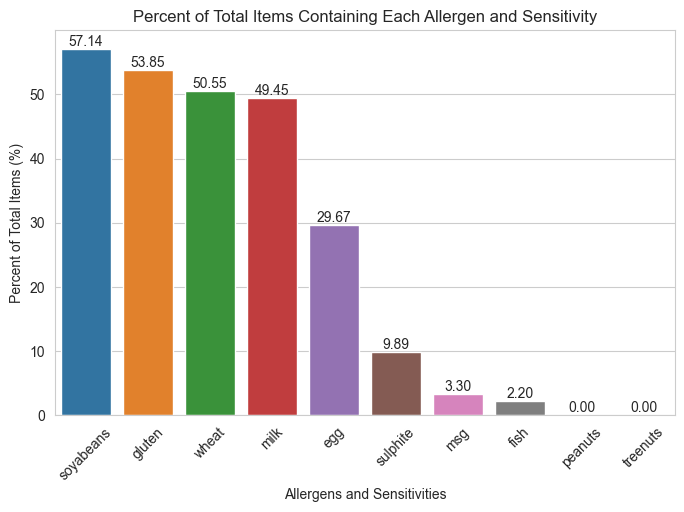

In [86]:
# get the total number of items in mcd menu
# get the total percentage of items in mcd menu containing each allergen or sensitivity
# convert series into dataframe

item_count = fullmenu.shape[0]

fullmenu_as = fullmenu[['egg', 'fish', 'milk', 'peanuts', 'soyabeans', 'treenuts', 'wheat', 'gluten', 'msg', 'sulphite']].sum()
df = pd.DataFrame({
    'allergen': fullmenu_as.index,
    'count': (fullmenu_as.values / item_count * 100).round(2)
}).sort_values(by='count', ascending=False)


# plot a bar chart showing number of items containing allergens or sensitivities
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))

bar = sns.barplot(
    x='allergen',
    y='count',
    data=df,
    errorbar=None
)

bar.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')

plt.xlabel('Allergens and Sensitivities')
plt.ylabel('Percent of Total Items (%)')
plt.title('Percent of Total Items Containing Each Allergen and Sensitivity')
plt.xticks(rotation = 45);

* majority of MCD's items contain soyabeans, gluten, wheat and milk

<br>

In [87]:
# define a function to aggregate sum / count of boolean values
def ratio(x):
    return round(x.sum() / x.count(), 2)

# group the dataframe by category and aggregate the percentage of total items in each category containing each allergen / sensitivity
temp = fullmenu.groupby(['category'], as_index=False).agg({
    'soyabeans': ratio,
    'gluten': ratio,
    'wheat': ratio,
    'milk': ratio
})

temp

,category,soyabeans,gluten,wheat,milk
0,beverages,0.10,0.16,0.06,0.42
1,breakfast,1.00,1.00,1.00,0.91
2,desserts,0.64,0.55,0.55,0.91
3,family,0.57,0.57,0.57,0.29
4,mains,1.00,1.00,1.00,0.44
5,sharing,1.00,1.00,1.00,0.00
6,sides,0.60,0.20,0.20,0.20


* all items in `mains`, `breakfast` and `sharing`  contain soybeans, gluten and wheat
* almost all items in `breakfast` and `desserts` contain milk

<br>

In [144]:
# create dataframes for breakfast_meal and lunch_meal
# assume that we do not upsize
# assume each lunch meal comes with a medium fries and small original coke
# for comparison sake, we won't include grilled chicken salad because its meal option usually comes with a corn cup and a bottle of water
# assume each breakfast meal comes with a hashbrown and mccafe premium roast coffee
# include the filet-o-fish and double filet-o-fish in breakfast_meal


# create the lunch_meal dataframe
lunch_meal = fullmenu[(fullmenu['category'] == 'mains') & (fullmenu['item'] != 'Grilled Chicken Salad')].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)
medium_fries = fullmenu[fullmenu['item'] == 'French Fries (Medium)'].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)
small_coke = fullmenu[fullmenu['item'] == 'Coca-Cola® Original Taste Less Sugar (Small)'].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)

medium_fries_broadcasted = medium_fries.loc[medium_fries.index.repeat(len(lunch_meal))].reset_index(drop=True)
small_coke_broadcasted = small_coke.loc[small_coke.index.repeat(len(lunch_meal))].reset_index(drop=True)

lunch_meal[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']] = lunch_meal[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']] .add(medium_fries_broadcasted[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']], axis=0).add(small_coke_broadcasted[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']], axis=0)
lunch_meal['category'] = 'lunch'


# create the breakfast_meal dataframe
breakfast_mains = fullmenu[(fullmenu['category'] == 'breakfast')].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)
breakfast_add = fullmenu[(fullmenu['item'].str.contains('filet-o-fish', case=False))].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)
breakfast_meal = pd.concat([breakfast_mains, breakfast_add], axis=0).reset_index(drop=True)

hashbrown = fullmenu[fullmenu['item'] == 'Hash Brown'].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)
coffee = fullmenu[fullmenu['item'] == 'McCafé® Premium Roast Coffee'].drop(columns=['category', 'soyabeans', 'gluten', 'wheat', 'milk', 'egg', 'sulphite', 'msg', 'fish', 'peanuts', 'treenuts']).reset_index(drop=True)

hashbrown_broadcasted = hashbrown.loc[hashbrown.index.repeat(len(breakfast_meal))].reset_index(drop=True)
coffee_broadcasted = coffee.loc[coffee.index.repeat(len(breakfast_meal))].reset_index(drop=True)

breakfast_meal[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']] = breakfast_meal[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']] .add(hashbrown_broadcasted[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']], axis=0).add(coffee_broadcasted[['energy_kcal', 'protein_g', 'totalfat_g', 'saturatedfat_g', 'cholesterol_mg', 'carbohydrates_g', 'dietaryfibres_g', 'sodium_mg']], axis=0)
breakfast_meal['category'] = 'breakfast'

# combine dataframes
meals = pd.concat([breakfast_meal, lunch_meal], axis=0).reset_index(drop=True)

<br>

## Calories

''

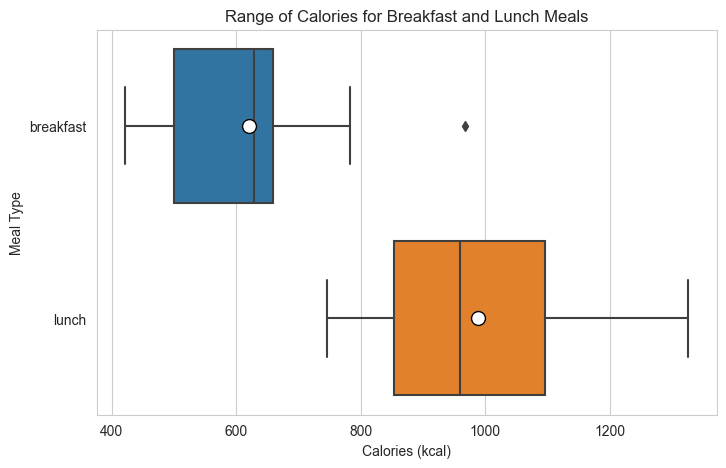

In [160]:
# plot the box plot to show range of calories for breakfast and lunch meals

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))

box = sns.boxplot(
    x='energy_kcal',
    y='category',
    data=meals,
    showmeans=True,
    meanprops={'marker': 'o',
                 'markerfacecolor': 'white',
                 'markeredgecolor': 'black',
                 'markersize': '10'}
    )

plt.title('Range of Calories for Breakfast and Lunch Meals')
plt.xlabel('Calories (kcal)')
plt.ylabel('Meal Type')
;

* Lunch meals contain significantly more calories as compared to breakfast meals in general. <br>
* There seems to be an outlier in the breakfast meal that contains a huge amount of calories.

<br>

In [162]:
# find the interquartile range, upper and lower limits for breakfast meal calories
upper_q = breakfast_meal['energy_kcal'].quantile(0.75)
lower_q = breakfast_meal['energy_kcal'].quantile(0.25)
iqr = upper_q - lower_q

upper_lim = upper_q+ 1.5 * iqr
lower_lim = lower_q + 1.5 - iqr

# filter the outlier with the limits
breakfast_meal[(breakfast_meal['energy_kcal'] <= lower_lim) | (breakfast_meal['energy_kcal'] >= upper_lim)]

,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,category
1,Breakfast Deluxe,968,35,37,11,487,121,7,1476,breakfast


* the calories in breakfast deluxe meal are way above the calories in other breakfast meals

<br>

## Cholesterol

''

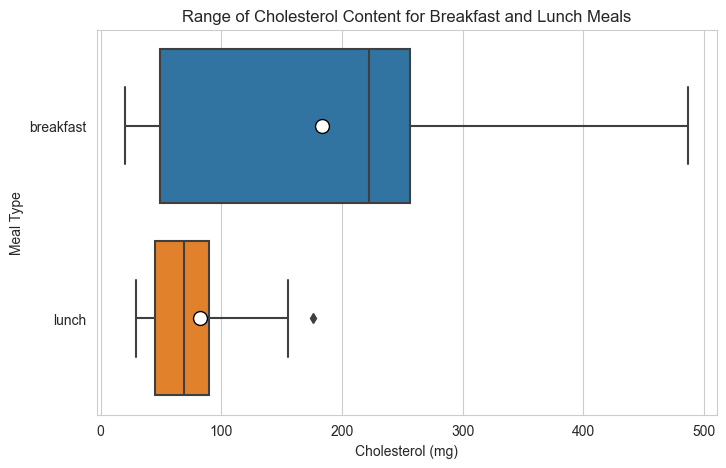

In [167]:
# plot the box plot to show range of cholesterol content for breakfast and lunch meals

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))

box = sns.boxplot(
    x='cholesterol_mg',
    y='category',
    data=meals,
    showmeans=True,
    meanprops={'marker': 'o',
                 'markerfacecolor': 'white',
                 'markeredgecolor': 'black',
                 'markersize': '10'}
    )

plt.title('Range of Cholesterol Content for Breakfast and Lunch Meals')
plt.xlabel('Cholesterol (mg)')
plt.ylabel('Meal Type')
;

* interestingly breakfast meals contain more cholesterol in general compared to lunch meals
* there seems to be an outlier in the lunch meal that contains almost the same amount of cholesterol as the average breakfast meal

<br>

In [173]:
# retrieve the top 5 breakfast meals with the highest cholesterol levels
breakfast_meal.sort_values(by='cholesterol_mg', ascending=False).head()

,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,category
1,Breakfast Deluxe,968,35,37,11,487,121,7,1476,breakfast
0,Big Breakfast®,659,31,30,7,418,64,6,1324,breakfast
10,Sausage McMuffin® with Egg,500,27,22,7,264,47,5,1085,breakfast
9,Chicken Muffin with Egg,644,27,34,8,256,56,5,1274,breakfast
4,Breakfast Wrap Chicken Sausage,635,26,32,10,236,61,6,1706,breakfast


In [169]:
# find the interquartile range, upper and lower limits for cholesterol content in lunch meals
upper_q = lunch_meal['cholesterol_mg'].quantile(0.75)
lower_q = lunch_meal['cholesterol_mg'].quantile(0.25)
iqr = upper_q - lower_q

upper_lim = upper_q+ 1.5 * iqr
lower_lim = lower_q + 1.5 - iqr

# filter the outlier with the limits
lunch_meal[(lunch_meal['cholesterol_mg'] <= lower_lim) | (lunch_meal['cholesterol_mg'] >= upper_lim)]

,item,energy_kcal,protein_g,totalfat_g,saturatedfat_g,cholesterol_mg,carbohydrates_g,dietaryfibres_g,sodium_mg,category
16,McWings® (4pc),1096,40,61,14,176,98,8,1606,lunch


* it is interesting that the breakfast wrap is amongst the top 5 breakfast meals with the highest cholesterol content
* McWings® (4pc) meal contains almost the same amount of cholesterol as the average breakfast meal

<br>

## Sodium

''

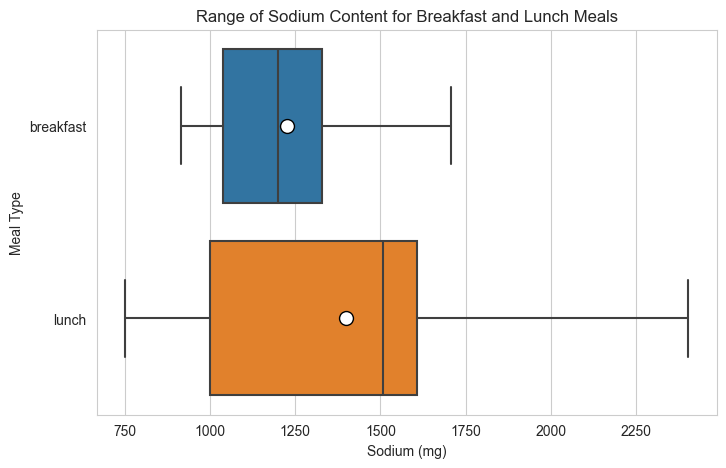

In [166]:
# plot the box plot to show range of sodium content for breakfast and lunch meals

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))

box = sns.boxplot(
    x='sodium_mg',
    y='category',
    data=meals,
    showmeans=True,
    meanprops={'marker': 'o',
                 'markerfacecolor': 'white',
                 'markeredgecolor': 'black',
                 'markersize': '10'}
    )

plt.title('Range of Sodium Content for Breakfast and Lunch Meals')
plt.xlabel('Sodium (mg)')
plt.ylabel('Meal Type')
;

* both the breakfast and lunch meals have similar level of sodium contents on average
* lunch meals have a wider range of sodium contents

<br>

## Fat

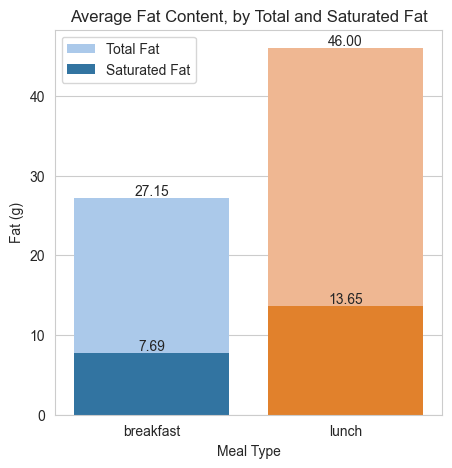

In [186]:
# plot an overlay bar plot to compare the average total and saturated fat content in breakfast and lunch meals

fat_content = meals

fat_content = fat_content.groupby(['category']).agg(
    saturatedfat_g=('saturatedfat_g', 'mean'),
    totalfat_g=('totalfat_g', 'mean')
).round(2)

fat_content = fat_content.reindex(['breakfast', 'lunch'])

sns.set_style('whitegrid')
plt.figure(figsize=(5, 5))

sns.set_palette('pastel')
box_top = sns.barplot(
    x = fat_content.index,
    y = 'totalfat_g',
    data = fat_content,
    errorbar = None,
    label = 'Total Fat',
)

sns.set_palette('tab10')
box_bot = sns.barplot(
    x = fat_content.index,
    y = 'saturatedfat_g',
    data = fat_content,
    errorbar = None,
    label = 'Saturated Fat'
)

box_top.bar_label(box_top.containers[0], fmt = '%.2f', label_type = 'edge')
box_bot.bar_label(box_bot.containers[1], fmt = '%.2f', label_type = 'edge')

ax = plt.gca()
plt.setp(ax.patches, linewidth=0)

plt.xlabel('Meal Type')
plt.ylabel('Fat (g)')
plt.title('Average Fat Content, by Total and Saturated Fat')
plt.legend();

* lunch meals contain 70 - 77% more total and saturated fat compared to breakfast meals

<br>

<br><br><br><br>

## Disclaimer & Acknowledgements
* data courtesy of Mcdonald's SG
* the content in this notebook does not draw conclusions or make claims on the overall nutritional benefits or drawbacks of the food at Mcdonald's SG